# Usage

This Jupyter notebook presents usage examples for features of `epymorph`.

## Basic usage

Start by constructing a simulation by combining a GEO, IPM, and MM. If the modules are registered in the data library, it's straightforward to import them from there. Once you have a Simulation, you can call the `run` method to generate the simulation's output.

In [1]:
from datetime import date

import numpy as np

from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.simulation import Simulation

# Note: the 'library' dictionaries contain functions which load the named component,
# so you have to apply the function to get the _actual_ component.

# The 'pei' model family (IPM/MM/GEO) implement an SIRS model in 6 US states.
# (Remember: it is possible to mix-and-match the models!)
sim = Simulation(
    geo=geo_library['pei'](),
    ipm_builder=ipm_library['pei'](),
    mvm_builder=mm_library['pei']()
)

Now that you have a simulation, you can call the `run` method to simulate the model for a set of input parameters. Note that it's perfectly legal to call `run` repeatedly, say for example, if you wanted to see how the output changes as you vary the parameters.

Which parameters do you need to supply? Each IPM and each MM define the parameters that they need to operate. At the moment, you'll have to inspect each of those to know for sure. (But this is something we hope to improve in the future.) There's no harm in providing extra, unused parameters, but if you are missing any you'll get an error.

In [2]:
out = sim.run(
    param={
        'theta': 0.1,
        'move_control': 0.9,
        'infection_duration': 4.0,
        'immunity_duration': 90.0,
        'infection_seed_loc': 0,
        'infection_seed_size': 10_000,
    },
    start_date=date(2015, 1, 1),
    duration_days=150,
    # I've provided a seeded RNG here just to keep this notebook's results consistent,
    # but the rng param is optional! If not given, a new RNG is constructed for each run
    # using numpy's default_rng.
    rng=np.random.default_rng(1)
)


The output object contains time-series prevalance (compartment) and incidence (event occurrence) data for each population in the GEO, as well as some metadata about the simulation that produced the output. Now we can inspect the results!

In [3]:
# We can access the results directly, say by printing out the SIR compartments
# for the the first population and first four timesteps.
print(out.prevalence[0:4, 0, :])


[[18798376    11290     1644]
 [18794126    12050     2567]
 [18793283    13419     4608]
 [18788521    14226     5754]]


The prevalence data is a 3-dimensional numpy array of integers of shape `(T,N,C)`, where `T` is the number of time steps in the simulation, `N` is the number of geo nodes, and `C` is the number of compartments in the IPM.

The incidence data is similar, but of shape `(T,N,E)`, where `E` is the number of transition events (directed edges from one IPM compartment to another, associated with some sort of transition rate).

We can also do more interesting things, like plot the data over time.

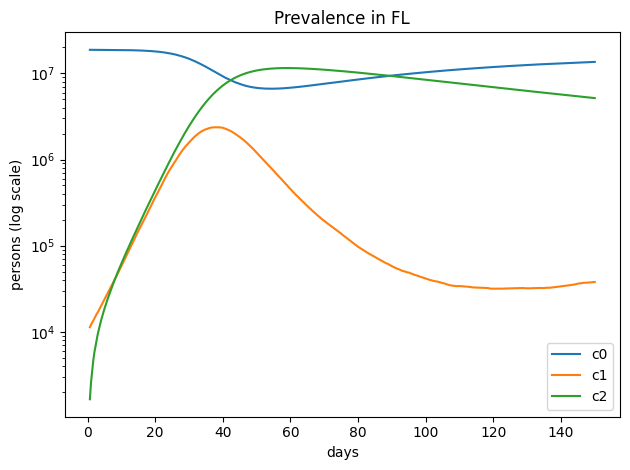

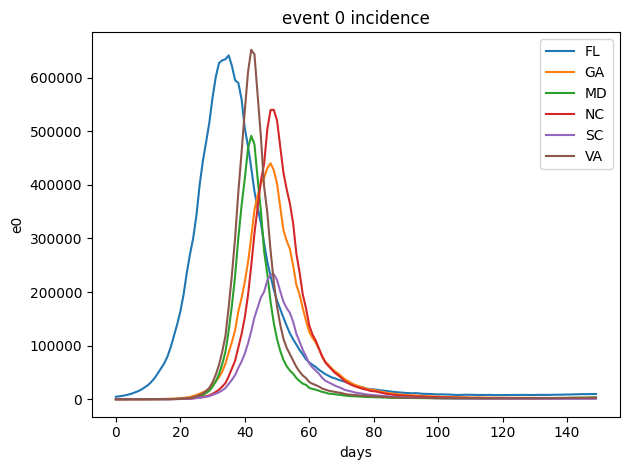

In [4]:
from epymorph.run import plot_event, plot_pop

plot_pop(out, 0)  # prevalence for all compartments in population 0.

plot_event(out, 0)  # incidence data for the S->I event across all populations.


There is a very limited set of built-in plots available (just those two at the moment), but behind the scenes we're using `matplotlib`, so you can certainly use that to create your own custom plots. To do that, you might need certain context info. The SimContext object attached to the Output object (`out.ctx`) provides useful meta-information about the output.

For example, a list of all the timesteps:

In [5]:
ts = out.ctx.clock.ticks
print(ts[0])
print(ts[1])
print(ts[2])
print(ts[3])


Tick(index=0, day=0, date=datetime.date(2015, 1, 1), step=0, tau=0.6666666666666666, tausum=0.6666666666666666)
Tick(index=1, day=0, date=datetime.date(2015, 1, 1), step=1, tau=0.3333333333333333, tausum=1)
Tick(index=2, day=1, date=datetime.date(2015, 1, 2), step=0, tau=0.6666666666666666, tausum=1.6666666666666665)
Tick(index=3, day=1, date=datetime.date(2015, 1, 2), step=1, tau=0.3333333333333333, tausum=2)


... how many nodes there were, and their labels:

In [6]:
print(f"There were {out.ctx.nodes} nodes!")
print(f"Whose labels are: {out.ctx.labels}")


There were 6 nodes!
Whose labels are: ['FL', 'GA', 'MD', 'NC', 'SC', 'VA']


... and so on!